# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'function_family': {
        'maximum_depth': 3,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,          
        'dt_type': 'vanilla', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 10, 
        'num_classes': 2,
        'categorical_indices': [0,1,2],
        
        'function_generation_type': 'random_decision_tree_trained',# 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
                
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    'evaluation': {   
    },    
    
    'computation':{
        'n_jobs': -3,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}




In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys

import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
#from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import tensorflow as tf
#import tensorflow_addons as tfa
import random 


#import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
    
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)

In [5]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='lambda_net'))
generate_directory_structure()
generate_lambda_net_directory(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_lambda_net_data)

print(path_identifier_function_data)


lNetSize5000_numLNets10000_var10_class2_random_decision_tree_trained_xMax1_xMin0_xDistuniform_depth3_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42
lNetSize5000_numDatasets10000_var10_class2_random_decision_tree_trained_xMax1_xMin0_xDistuniform_depth3_beta1_decisionSpars1_vanilla_fullyGrown


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


In [8]:
lambda_network_layers

[128]

In [9]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df = pd.read_csv(path_functions)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
if number_of_trained_lambda_nets < number_of_generated_datasets:
    function_df = function_df.sample(n=number_of_trained_lambda_nets, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)

## Data Inspection

In [10]:
function_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,split0,split1,split2,split3,split4,split5,split6,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7
0,0.348,0.332,0.553,0.328,0.323,0.028,0.402,6.000,6.000,6.000,6.000,5.000,8.000,4.000,0.470,0.783,0.059,0.380,0.276,0.567,0.536,0.469
1,0.362,0.491,0.365,0.066,0.022,0.234,0.073,9.000,5.000,9.000,6.000,9.000,4.000,8.000,0.750,0.564,0.254,0.501,0.667,0.000,0.559,0.478
2,0.893,0.003,0.958,0.942,0.468,0.730,0.189,9.000,4.000,9.000,6.000,9.000,8.000,6.000,1.000,0.333,0.507,0.467,0.568,0.744,0.286,0.533
3,0.263,0.006,0.625,-1.000,0.102,0.079,0.704,4.000,5.000,4.000,-1.000,7.000,9.000,4.000,0.000,0.000,0.641,0.524,0.558,0.443,0.573,0.492
4,0.996,0.997,0.813,0.507,0.562,-1.000,-1.000,5.000,8.000,3.000,6.000,4.000,-1.000,-1.000,0.524,0.487,1.000,0.615,1.000,1.000,0.000,0.000


In [11]:
X_data_list[0][0].head(10)

feat0    0.348
feat1    0.332
feat2    0.553
feat3    0.328
feat4    0.323
feat5    0.028
feat6    0.402
split0   6.000
split1   6.000
split2   6.000
dtype: float64

In [12]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,1.000,0.000,1.000,0.180,0.589,0.121,0.555,0.082,0.993,0.253
1,1.000,1.000,0.000,0.418,0.868,0.286,0.138,0.051,0.928,0.780
2,1.000,1.000,1.000,0.207,0.223,0.998,0.492,0.226,0.988,0.757
3,1.000,1.000,0.000,0.453,0.817,0.102,0.917,0.044,0.575,0.180
4,1.000,1.000,1.000,0.254,0.597,0.920,0.775,0.291,0.687,0.433
5,0.000,0.000,0.000,0.018,0.972,0.584,0.062,0.626,0.606,0.277
6,0.000,0.000,1.000,0.422,0.997,0.652,0.492,0.834,0.745,0.210
7,1.000,0.000,1.000,0.541,0.807,0.825,0.520,0.080,0.070,0.447
8,1.000,0.000,0.000,0.632,0.146,0.358,0.538,0.419,0.682,0.675
9,1.000,1.000,0.000,0.149,0.896,0.519,0.519,0.011,0.242,0.740


In [13]:
y_data_list[0][0].head(10)

feat0    0.348
feat1    0.332
feat2    0.553
feat3    0.328
feat4    0.323
feat5    0.028
feat6    0.402
split0   6.000
split1   6.000
split2   6.000
dtype: float64

In [14]:
y_data_list[0][1].head(10)

,result
0,1
1,1
2,0
3,1
4,1
5,1
6,0
7,0
8,0
9,0


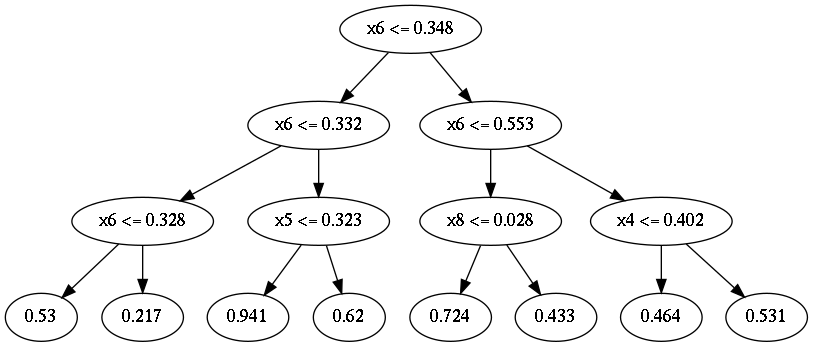

In [15]:
plot_tree_from_parameters(y_data_list[0][0].values, config)

In [16]:
def inject_noise(y_data, noise=0.0, noise_dist='normal', seed=42):
    """
    Returns a polynomial injected with specified noise type and amount. 
    Inputs a clean polynomial array with x-data and y-data and modifies the y-data according to the noise settings.
    """
    np.random.seed(seed)
    
    #Calculate range of function values of input polynomial
    range_values_fv = np.ptp(y_data[1].values)
    
    #Selection of noise type
    #Available types: normal, uniform, A, B, C
    if noise_dist=='normal':
        noise_sample=noise*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform':
        noise_sample=noise*np.random.uniform(low=0, high=1.0,size=y_data[1].shape[0])
    elif noise_dist=='normal_range':
        #Normal distribution adjusted to function value range
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform_range':
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='flip_percentage':
        idx = np.random.choice(y_data[1].shape[0], int(y_data[1].shape[0]*noise), replace=False)
        y_data[1].iloc[idx] = (y_data[1].iloc[idx] + 1) % 2 
        #y_data[1].reshape(-1, 1)
        return y_data
    else:
        #no noise
        noise_sample = np.zeros(y_data[1].shape[0])
                               
    noise_sample=noise_sample.reshape(-1,1)
    
    y_data[1]=y_data[1]+noise_sample
    
    return np.clip(y_data, 0, 1)

In [17]:
if noise_injected_level > 0:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    y_data_list = parallel(delayed(inject_noise)(y_data=y_data_list[i],
                                                 noise=noise_injected_level,
                                                 noise_dist=noise_injected_type, 
                                                 seed=RANDOM_SEED+i) for i in range(len(y_data_list)))


In [18]:
y_data_list[0][0].head(10)

feat0    0.348
feat1    0.332
feat2    0.553
feat3    0.328
feat4    0.323
feat5    0.028
feat6    0.402
split0   6.000
split1   6.000
split2   6.000
dtype: float64

In [19]:
y_data_list[0][0]

feat0    0.348
feat1    0.332
feat2    0.553
feat3    0.328
feat4    0.323
feat5    0.028
feat6    0.402
split0   6.000
split1   6.000
split2   6.000
split3   6.000
split4   5.000
split5   8.000
split6   4.000
lp0      0.470
lp1      0.783
lp2      0.059
lp3      0.380
lp4      0.276
lp5      0.567
lp6      0.536
lp7      0.469
dtype: float64

In [20]:
y_data_list[0][1].head(10)

,result
0,1
1,1
2,0
3,1
4,1
5,1
6,0
7,0
8,0
9,0


## Lambda Network Training + Weigh/Bias saving

In [21]:
#%load_ext autoreload

In [22]:
rand_index = np.random.randint(number_of_trained_lambda_nets)

#rand_tree = generate_decision_tree_from_array(y_data_list[rand_index][0].values, config)
#rand_tree.plot_tree()

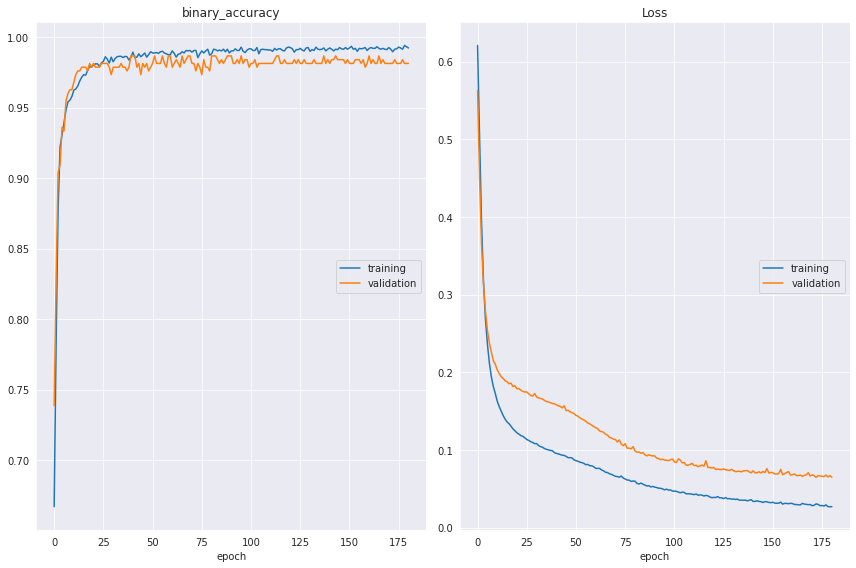

binary_accuracy
	training         	 (min:    0.667, max:    0.994, cur:    0.992)
	validation       	 (min:    0.739, max:    0.987, cur:    0.981)
Loss
	training         	 (min:    0.027, max:    0.621, cur:    0.027)
	validation       	 (min:    0.065, max:    0.563, cur:    0.065)


In [23]:
#%autoreload 2
random_network = train_lambda_net(config=config,
                                  lambda_index=rand_index, 
                                  X_data_with_function=X_data_list[rand_index], 
                                  y_data_with_function=y_data_list[rand_index], 
                                  callbacks=[PlotLossesKerasTF()], 
                                  return_model=True,
                                  printing=False)

In [24]:
#%autoreload 2
parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky
clf_list = parallel(delayed(train_lambda_net)(config=config,
                                              lambda_index=index, 
                                              X_data_with_function=X_data, 
                                              y_data_with_function=y_data,
                                              return_history=True, 
                                              printing=True) for index, (X_data, y_data) in enumerate(zip(X_data_list, y_data_list)))  
del parallel

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done  84 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-3)]: Done 244 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-3)]: Done 468 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-3)]: Done 756 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-3)]: Done 1108 tasks      | elapsed: 38.4min
[Parallel(n_jobs=-3)]: Done 1524 tasks      | elapsed: 52.4min
[Parallel(n_jobs=-3)]: Done 2004 tasks      | elapsed: 69.1min
[Parallel(n_jobs=-3)]: Done 2548 tasks      | elapsed: 87.6min
[Parallel(n_jobs=-3)]: Done 3156 tasks      | elapsed: 109.2min
[Parallel(n_jobs=-3)]: Done 3828 tasks      | elapsed: 133.1min
[Parallel(n_jobs=-3)]: Done 4564 tasks      | elapsed: 159.0min
[Parallel(n_jobs=-3)]: Done 5364 tasks      | elapsed: 186.5min
[Parallel(n_jobs=-3)]: Done 6228 tasks      | elapsed: 216.0min
[Parallel(n_jobs=-3)]: Done 7156 tasks      | elapsed: 248.0min
[Parallel(n_jobs=-3)]: Done 8148 tasks 

In [25]:
random_network['model'].get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'units': 128,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 1,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initial

In [26]:
random_network['model'].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


## Save and Plot Lambda-Model History

In [27]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

index_list = []


max_training_epochs = 0
for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    max_training_epochs = max(max_training_epochs, current_training_epochs)


for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    index = entry['index']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    
    loss_list = np.full(max_training_epochs, np.nan)
    metric_list = np.full(max_training_epochs, np.nan)
    val_loss_list = np.full(max_training_epochs, np.nan)
    val_metric_list = np.full(max_training_epochs, np.nan) 

    for i in range(current_training_epochs):  
        loss_list[i] = history[list(history.keys())[0]][i]
        metric_list[i] = history[list(history.keys())[1]][i]
        val_loss_list[i] = history[list(history.keys())[len(history.keys())//2]][i]
        val_metric_list[i] = history[list(history.keys())[len(history.keys())//2+1]][i]
    
    index_list.append([index])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=np.hstack([index_list, loss_list_total]), columns=flatten_list(['index', [list(history.keys())[0] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#loss_df['index'] = loss_df['index'].astype(int)
metric_df = pd.DataFrame(data=np.hstack([index_list, metric_list_total]), columns=flatten_list(['index', [list(history.keys())[1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#metric_df['index'] = metric_df['index'].astype(int)
val_loss_df = pd.DataFrame(data=np.hstack([index_list, val_loss_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#val_loss_df['index'] = val_loss_df['index'].astype(int)
val_metric_df = pd.DataFrame(data=np.hstack([index_list, val_metric_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])) 
#val_metric_df['index'] = val_metric_df['index'].astype(int)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [28]:
path_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[0] + '.txt'
path_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[1] + '.txt'
path_val_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2] + '.txt'
path_val_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2+1] + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [29]:
loss_df.describe()

,index,loss_epoch_1,loss_epoch_2,loss_epoch_3,loss_epoch_4,loss_epoch_5,loss_epoch_6,loss_epoch_7,loss_epoch_8,loss_epoch_9,loss_epoch_10,loss_epoch_11,loss_epoch_12,loss_epoch_13,loss_epoch_14,loss_epoch_15,loss_epoch_16,loss_epoch_17,loss_epoch_18,loss_epoch_19,loss_epoch_20,loss_epoch_21,loss_epoch_22,loss_epoch_23,loss_epoch_24,loss_epoch_25,loss_epoch_26,loss_epoch_27,loss_epoch_28,loss_epoch_29,loss_epoch_30,loss_epoch_31,loss_epoch_32,loss_epoch_33,loss_epoch_34,loss_epoch_35,loss_epoch_36,loss_epoch_37,loss_epoch_38,loss_epoch_39,loss_epoch_40,loss_epoch_41,loss_epoch_42,loss_epoch_43,loss_epoch_44,loss_epoch_45,loss_epoch_46,loss_epoch_47,loss_epoch_48,loss_epoch_49,loss_epoch_50,loss_epoch_51,loss_epoch_52,loss_epoch_53,loss_epoch_54,loss_epoch_55,loss_epoch_56,loss_epoch_57,loss_epoch_58,loss_epoch_59,loss_epoch_60,loss_epoch_61,loss_epoch_62,loss_epoch_63,loss_epoch_64,loss_epoch_65,loss_epoch_66,loss_epoch_67,loss_epoch_68,loss_epoch_69,loss_epoch_70,loss_epoch_71,loss_epoch_72,loss_epoch_73,loss_epoch_74,loss_epoch_75,loss_epoch_76,loss_epoch_77,loss_epoch_78,loss_epoch_79,loss_epoch_80,loss_epoch_81,loss_epoch_82,loss_epoch_83,loss_epoch_84,loss_epoch_85,loss_epoch_86,loss_epoch_87,loss_epoch_88,loss_epoch_89,loss_epoch_90,loss_epoch_91,loss_epoch_92,loss_epoch_93,loss_epoch_94,loss_epoch_95,loss_epoch_96,loss_epoch_97,loss_epoch_98,loss_epoch_99,...,loss_epoch_485,loss_epoch_486,loss_epoch_487,loss_epoch_488,loss_epoch_489,loss_epoch_490,loss_epoch_491,loss_epoch_492,loss_epoch_493,loss_epoch_494,loss_epoch_495,loss_epoch_496,loss_epoch_497,loss_epoch_498,loss_epoch_499,loss_epoch_500,loss_epoch_501,loss_epoch_502,loss_epoch_503,loss_epoch_504,loss_epoch_505,loss_epoch_506,loss_epoch_507,loss_epoch_508,loss_epoch_509,loss_epoch_510,loss_epoch_511,loss_epoch_512,loss_epoch_513,loss_epoch_514,loss_epoch_515,loss_epoch_516,loss_epoch_517,loss_epoch_518,loss_epoch_519,loss_epoch_520,loss_epoch_521,loss_epoch_522,loss_epoch_523,loss_epoch_524,loss_epoch_525,loss_epoch_526,loss_epoch_527,loss_epoch_528,loss_epoch_529,loss_epoch_530,loss_epoch_531,loss_epoch_532,loss_epoch_533,loss_epoch_534,loss_epoch_535,loss_epoch_536,loss_epoch_537,loss_epoch_538,loss_epoch_539,loss_epoch_540,loss_epoch_541,loss_epoch_542,loss_epoch_543,loss_epoch_544,loss_epoch_545,loss_epoch_546,loss_epoch_547,loss_epoch_548,loss_epoch_549,loss_epoch_550,loss_epoch_551,loss_epoch_552,loss_epoch_553,loss_epoch_554,loss_epoch_555,loss_epoch_556,loss_epoch_557,loss_epoch_558,loss_epoch_559,loss_epoch_560,loss_epoch_561,loss_epoch_562,loss_epoch_563,loss_epoch_564,loss_epoch_565,loss_epoch_566,loss_epoch_567,loss_epoch_568,loss_epoch_569,loss_epoch_570,loss_epoch_571,loss_epoch_572,loss_epoch_573,loss_epoch_574,loss_epoch_575,loss_epoch_576,loss_epoch_577,loss_epoch_578,loss_epoch_579,loss_epoch_580,loss_epoch_581,loss_epoch_582,loss_epoch_583,loss_epoch_584
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,9998.000,9995.000,9995.000,9981.000,9975.000,9964.000,9961.000,9955.000,9949.000,9944.000,9933.000,9925.000,9915.000,9898.000,9890.000,9881.000,9871.000,9858.000,9849.000,9832.000,9821.000,9802.000,9788.000,9780.000,9761.000,9750.000,9743.000,9726.000,9709.000,9696.000,9678.000,9661.000,9641.000,9628.000,9615.000,9599.000,9584.000,9569.000,9550.000,9523.000,9501.000,9480.000,9463.000,9441.000,9409.000,...,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,7.000,6.000,6.000,6.000,6.000,6.000,6.0

In [30]:
val_loss_df.describe()

,index,val_loss_epoch_1,val_loss_epoch_2,val_loss_epoch_3,val_loss_epoch_4,val_loss_epoch_5,val_loss_epoch_6,val_loss_epoch_7,val_loss_epoch_8,val_loss_epoch_9,val_loss_epoch_10,val_loss_epoch_11,val_loss_epoch_12,val_loss_epoch_13,val_loss_epoch_14,val_loss_epoch_15,val_loss_epoch_16,val_loss_epoch_17,val_loss_epoch_18,val_loss_epoch_19,val_loss_epoch_20,val_loss_epoch_21,val_loss_epoch_22,val_loss_epoch_23,val_loss_epoch_24,val_loss_epoch_25,val_loss_epoch_26,val_loss_epoch_27,val_loss_epoch_28,val_loss_epoch_29,val_loss_epoch_30,val_loss_epoch_31,val_loss_epoch_32,val_loss_epoch_33,val_loss_epoch_34,val_loss_epoch_35,val_loss_epoch_36,val_loss_epoch_37,val_loss_epoch_38,val_loss_epoch_39,val_loss_epoch_40,val_loss_epoch_41,val_loss_epoch_42,val_loss_epoch_43,val_loss_epoch_44,val_loss_epoch_45,val_loss_epoch_46,val_loss_epoch_47,val_loss_epoch_48,val_loss_epoch_49,val_loss_epoch_50,val_loss_epoch_51,val_loss_epoch_52,val_loss_epoch_53,val_loss_epoch_54,val_loss_epoch_55,val_loss_epoch_56,val_loss_epoch_57,val_loss_epoch_58,val_loss_epoch_59,val_loss_epoch_60,val_loss_epoch_61,val_loss_epoch_62,val_loss_epoch_63,val_loss_epoch_64,val_loss_epoch_65,val_loss_epoch_66,val_loss_epoch_67,val_loss_epoch_68,val_loss_epoch_69,val_loss_epoch_70,val_loss_epoch_71,val_loss_epoch_72,val_loss_epoch_73,val_loss_epoch_74,val_loss_epoch_75,val_loss_epoch_76,val_loss_epoch_77,val_loss_epoch_78,val_loss_epoch_79,val_loss_epoch_80,val_loss_epoch_81,val_loss_epoch_82,val_loss_epoch_83,val_loss_epoch_84,val_loss_epoch_85,val_loss_epoch_86,val_loss_epoch_87,val_loss_epoch_88,val_loss_epoch_89,val_loss_epoch_90,val_loss_epoch_91,val_loss_epoch_92,val_loss_epoch_93,val_loss_epoch_94,val_loss_epoch_95,val_loss_epoch_96,val_loss_epoch_97,val_loss_epoch_98,val_loss_epoch_99,...,val_loss_epoch_485,val_loss_epoch_486,val_loss_epoch_487,val_loss_epoch_488,val_loss_epoch_489,val_loss_epoch_490,val_loss_epoch_491,val_loss_epoch_492,val_loss_epoch_493,val_loss_epoch_494,val_loss_epoch_495,val_loss_epoch_496,val_loss_epoch_497,val_loss_epoch_498,val_loss_epoch_499,val_loss_epoch_500,val_loss_epoch_501,val_loss_epoch_502,val_loss_epoch_503,val_loss_epoch_504,val_loss_epoch_505,val_loss_epoch_506,val_loss_epoch_507,val_loss_epoch_508,val_loss_epoch_509,val_loss_epoch_510,val_loss_epoch_511,val_loss_epoch_512,val_loss_epoch_513,val_loss_epoch_514,val_loss_epoch_515,val_loss_epoch_516,val_loss_epoch_517,val_loss_epoch_518,val_loss_epoch_519,val_loss_epoch_520,val_loss_epoch_521,val_loss_epoch_522,val_loss_epoch_523,val_loss_epoch_524,val_loss_epoch_525,val_loss_epoch_526,val_loss_epoch_527,val_loss_epoch_528,val_loss_epoch_529,val_loss_epoch_530,val_loss_epoch_531,val_loss_epoch_532,val_loss_epoch_533,val_loss_epoch_534,val_loss_epoch_535,val_loss_epoch_536,val_loss_epoch_537,val_loss_epoch_538,val_loss_epoch_539,val_loss_epoch_540,val_loss_epoch_541,val_loss_epoch_542,val_loss_epoch_543,val_loss_epoch_544,val_loss_epoch_545,val_loss_epoch_546,val_loss_epoch_547,val_loss_epoch_548,val_loss_epoch_549,val_loss_epoch_550,val_loss_epoch_551,val_loss_epoch_552,val_loss_epoch_553,val_loss_epoch_554,val_loss_epoch_555,val_loss_epoch_556,val_loss_epoch_557,val_loss_epoch_558,val_loss_epoch_559,val_loss_epoch_560,val_loss_epoch_561,val_loss_epoch_562,val_loss_epoch_563,val_loss_epoch_564,val_loss_epoch_565,val_loss_epoch_566,val_loss_epoch_567,val_loss_epoch_568,val_loss_epoch_569,val_loss_epoch_570,val_loss_epoch_571,val_loss_epoch_572,val_loss_epoch_573,val_loss_epoch_574,val_loss_epoch_575,val_loss_epoch_576,val_loss_epoch_577,val_loss_epoch_578,val_loss_epoch_579,val_loss_epoch_580,val_loss_epoch_581,val_loss_epoch_582,val_loss_epoch_583,val_loss_epoch_584
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,

In [31]:
metric_df.describe()

,index,binary_accuracy_epoch_1,binary_accuracy_epoch_2,binary_accuracy_epoch_3,binary_accuracy_epoch_4,binary_accuracy_epoch_5,binary_accuracy_epoch_6,binary_accuracy_epoch_7,binary_accuracy_epoch_8,binary_accuracy_epoch_9,binary_accuracy_epoch_10,binary_accuracy_epoch_11,binary_accuracy_epoch_12,binary_accuracy_epoch_13,binary_accuracy_epoch_14,binary_accuracy_epoch_15,binary_accuracy_epoch_16,binary_accuracy_epoch_17,binary_accuracy_epoch_18,binary_accuracy_epoch_19,binary_accuracy_epoch_20,binary_accuracy_epoch_21,binary_accuracy_epoch_22,binary_accuracy_epoch_23,binary_accuracy_epoch_24,binary_accuracy_epoch_25,binary_accuracy_epoch_26,binary_accuracy_epoch_27,binary_accuracy_epoch_28,binary_accuracy_epoch_29,binary_accuracy_epoch_30,binary_accuracy_epoch_31,binary_accuracy_epoch_32,binary_accuracy_epoch_33,binary_accuracy_epoch_34,binary_accuracy_epoch_35,binary_accuracy_epoch_36,binary_accuracy_epoch_37,binary_accuracy_epoch_38,binary_accuracy_epoch_39,binary_accuracy_epoch_40,binary_accuracy_epoch_41,binary_accuracy_epoch_42,binary_accuracy_epoch_43,binary_accuracy_epoch_44,binary_accuracy_epoch_45,binary_accuracy_epoch_46,binary_accuracy_epoch_47,binary_accuracy_epoch_48,binary_accuracy_epoch_49,binary_accuracy_epoch_50,binary_accuracy_epoch_51,binary_accuracy_epoch_52,binary_accuracy_epoch_53,binary_accuracy_epoch_54,binary_accuracy_epoch_55,binary_accuracy_epoch_56,binary_accuracy_epoch_57,binary_accuracy_epoch_58,binary_accuracy_epoch_59,binary_accuracy_epoch_60,binary_accuracy_epoch_61,binary_accuracy_epoch_62,binary_accuracy_epoch_63,binary_accuracy_epoch_64,binary_accuracy_epoch_65,binary_accuracy_epoch_66,binary_accuracy_epoch_67,binary_accuracy_epoch_68,binary_accuracy_epoch_69,binary_accuracy_epoch_70,binary_accuracy_epoch_71,binary_accuracy_epoch_72,binary_accuracy_epoch_73,binary_accuracy_epoch_74,binary_accuracy_epoch_75,binary_accuracy_epoch_76,binary_accuracy_epoch_77,binary_accuracy_epoch_78,binary_accuracy_epoch_79,binary_accuracy_epoch_80,binary_accuracy_epoch_81,binary_accuracy_epoch_82,binary_accuracy_epoch_83,binary_accuracy_epoch_84,binary_accuracy_epoch_85,binary_accuracy_epoch_86,binary_accuracy_epoch_87,binary_accuracy_epoch_88,binary_accuracy_epoch_89,binary_accuracy_epoch_90,binary_accuracy_epoch_91,binary_accuracy_epoch_92,binary_accuracy_epoch_93,binary_accuracy_epoch_94,binary_accuracy_epoch_95,binary_accuracy_epoch_96,binary_accuracy_epoch_97,binary_accuracy_epoch_98,binary_accuracy_epoch_99,...,binary_accuracy_epoch_485,binary_accuracy_epoch_486,binary_accuracy_epoch_487,binary_accuracy_epoch_488,binary_accuracy_epoch_489,binary_accuracy_epoch_490,binary_accuracy_epoch_491,binary_accuracy_epoch_492,binary_accuracy_epoch_493,binary_accuracy_epoch_494,binary_accuracy_epoch_495,binary_accuracy_epoch_496,binary_accuracy_epoch_497,binary_accuracy_epoch_498,binary_accuracy_epoch_499,binary_accuracy_epoch_500,binary_accuracy_epoch_501,binary_accuracy_epoch_502,binary_accuracy_epoch_503,binary_accuracy_epoch_504,binary_accuracy_epoch_505,binary_accuracy_epoch_506,binary_accuracy_epoch_507,binary_accuracy_epoch_508,binary_accuracy_epoch_509,binary_accuracy_epoch_510,binary_accuracy_epoch_511,binary_accuracy_epoch_512,binary_accuracy_epoch_513,binary_accuracy_epoch_514,binary_accuracy_epoch_515,binary_accuracy_epoch_516,binary_accuracy_epoch_517,binary_accuracy_epoch_518,binary_accuracy_epoch_519,binary_accuracy_epoch_520,binary_accuracy_epoch_521,binary_accuracy_epoch_522,binary_accuracy_epoch_523,binary_accuracy_epoch_524,binary_accuracy_epoch_525,binary_accuracy_epoch_526,binary_accuracy_epoch_527,binary_accuracy_epoch_528,binary_accuracy_epoch_529,binary_accuracy_epoch_530,binary_accuracy_epoch_531,binary_accuracy_epoch_532,binary_accuracy_epoch_533,binary_accuracy_epoch_534,binary_accuracy_epoch_535,binary_accuracy_epoch_536,binary_accuracy_epoch_537,binary_accuracy_epoch_538,binary_accuracy_epoch_539,binary_accuracy_epoch_540,binary_accuracy_epoch_541,binary_accuracy_epoch_542,binary_accuracy

In [32]:
val_metric_df.describe()

,index,val_binary_accuracy_epoch_1,val_binary_accuracy_epoch_2,val_binary_accuracy_epoch_3,val_binary_accuracy_epoch_4,val_binary_accuracy_epoch_5,val_binary_accuracy_epoch_6,val_binary_accuracy_epoch_7,val_binary_accuracy_epoch_8,val_binary_accuracy_epoch_9,val_binary_accuracy_epoch_10,val_binary_accuracy_epoch_11,val_binary_accuracy_epoch_12,val_binary_accuracy_epoch_13,val_binary_accuracy_epoch_14,val_binary_accuracy_epoch_15,val_binary_accuracy_epoch_16,val_binary_accuracy_epoch_17,val_binary_accuracy_epoch_18,val_binary_accuracy_epoch_19,val_binary_accuracy_epoch_20,val_binary_accuracy_epoch_21,val_binary_accuracy_epoch_22,val_binary_accuracy_epoch_23,val_binary_accuracy_epoch_24,val_binary_accuracy_epoch_25,val_binary_accuracy_epoch_26,val_binary_accuracy_epoch_27,val_binary_accuracy_epoch_28,val_binary_accuracy_epoch_29,val_binary_accuracy_epoch_30,val_binary_accuracy_epoch_31,val_binary_accuracy_epoch_32,val_binary_accuracy_epoch_33,val_binary_accuracy_epoch_34,val_binary_accuracy_epoch_35,val_binary_accuracy_epoch_36,val_binary_accuracy_epoch_37,val_binary_accuracy_epoch_38,val_binary_accuracy_epoch_39,val_binary_accuracy_epoch_40,val_binary_accuracy_epoch_41,val_binary_accuracy_epoch_42,val_binary_accuracy_epoch_43,val_binary_accuracy_epoch_44,val_binary_accuracy_epoch_45,val_binary_accuracy_epoch_46,val_binary_accuracy_epoch_47,val_binary_accuracy_epoch_48,val_binary_accuracy_epoch_49,val_binary_accuracy_epoch_50,val_binary_accuracy_epoch_51,val_binary_accuracy_epoch_52,val_binary_accuracy_epoch_53,val_binary_accuracy_epoch_54,val_binary_accuracy_epoch_55,val_binary_accuracy_epoch_56,val_binary_accuracy_epoch_57,val_binary_accuracy_epoch_58,val_binary_accuracy_epoch_59,val_binary_accuracy_epoch_60,val_binary_accuracy_epoch_61,val_binary_accuracy_epoch_62,val_binary_accuracy_epoch_63,val_binary_accuracy_epoch_64,val_binary_accuracy_epoch_65,val_binary_accuracy_epoch_66,val_binary_accuracy_epoch_67,val_binary_accuracy_epoch_68,val_binary_accuracy_epoch_69,val_binary_accuracy_epoch_70,val_binary_accuracy_epoch_71,val_binary_accuracy_epoch_72,val_binary_accuracy_epoch_73,val_binary_accuracy_epoch_74,val_binary_accuracy_epoch_75,val_binary_accuracy_epoch_76,val_binary_accuracy_epoch_77,val_binary_accuracy_epoch_78,val_binary_accuracy_epoch_79,val_binary_accuracy_epoch_80,val_binary_accuracy_epoch_81,val_binary_accuracy_epoch_82,val_binary_accuracy_epoch_83,val_binary_accuracy_epoch_84,val_binary_accuracy_epoch_85,val_binary_accuracy_epoch_86,val_binary_accuracy_epoch_87,val_binary_accuracy_epoch_88,val_binary_accuracy_epoch_89,val_binary_accuracy_epoch_90,val_binary_accuracy_epoch_91,val_binary_accuracy_epoch_92,val_binary_accuracy_epoch_93,val_binary_accuracy_epoch_94,val_binary_accuracy_epoch_95,val_binary_accuracy_epoch_96,val_binary_accuracy_epoch_97,val_binary_accuracy_epoch_98,val_binary_accuracy_epoch_99,...,val_binary_accuracy_epoch_485,val_binary_accuracy_epoch_486,val_binary_accuracy_epoch_487,val_binary_accuracy_epoch_488,val_binary_accuracy_epoch_489,val_binary_accuracy_epoch_490,val_binary_accuracy_epoch_491,val_binary_accuracy_epoch_492,val_binary_accuracy_epoch_493,val_binary_accuracy_epoch_494,val_binary_accuracy_epoch_495,val_binary_accuracy_epoch_496,val_binary_accuracy_epoch_497,val_binary_accuracy_epoch_498,val_binary_accuracy_epoch_499,val_binary_accuracy_epoch_500,val_binary_accuracy_epoch_501,val_binary_accuracy_epoch_502,val_binary_accuracy_epoch_503,val_binary_accuracy_epoch_504,val_binary_accuracy_epoch_505,val_binary_accuracy_epoch_506,val_binary_accuracy_epoch_507,val_binary_accuracy_epoch_508,val_binary_accuracy_epoch_509,val_binary_accuracy_epoch_510,val_binary_accuracy_epoch_511,val_binary_accuracy_epoch_512,val_binary_accuracy_epoch_513,val_binary_accuracy_epoch_514,val_binary_accuracy_epoch_515,val_binary_accuracy_epoch_516,val_binary_accuracy_epoch_517,val_binary_accuracy_epoch_518,val_binary_accuracy_epoch_519,val_binary_accuracy_epoch_520,val_binary_accuracy_epoch_521,val_binary_accura

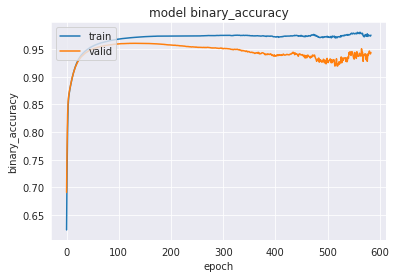

In [33]:
# summarize history for metric
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[1] + '.png'

adjustment_threshold_metric = 10#100
    
metric_df_adjusted = metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[1])
plt.ylabel(list(history.keys())[1])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


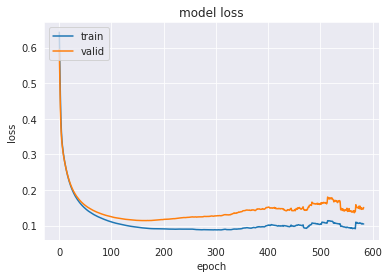

In [34]:
# summarize history for loss
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[0] + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True).iloc[:,1:]

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[0])
plt.ylabel(list(history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()
